# Training the ConvNP Model 

In this notebook, we will preprocess Great Lakes data using an existing data processor, generate tasks for model training, and set up a training loop to train a **ConvNP** model using DeepSensor. We will:
1. Load and preprocess temporal and static datasets like **SST**, **Ice Concentration**, **Lake Mask**, and **Bathymetry**.
2. Load and use an existing **DataProcessor** to handle data normalization.
3. Generate tasks using **TaskLoader** and train the **ConvNP** model.
4. Monitor validation performance and track model training losses and RMSE (Root Mean Squared Error).

Let's begin by importing necessary packages and defining helper functions.


## Step 1: Import Packages and Define Helper Functions

We import the libraries required for:
- Data manipulation and visualization (`xarray`, `pandas`, `matplotlib`).
- Geospatial operations (`cartopy`).
- Efficient computation with Dask (`dask`).
- DeepSensor for data processing and model training (`deepsensor`).

Additionally, we define helper functions such as `standardize_dates`, which standardizes the 'time' dimension in the dataset to a date-only format (`datetime64[D]`). We also define `generate_random_coordinates` and custom save and load functions, as the default functions in DeepSensor appear to be broken in this environment. 


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da
import gcsfs
import os

import deepsensor.torch
from deepsensor.data import DataProcessor, TaskLoader, construct_circ_time_ds
from deepsensor.data.sources import get_era5_reanalysis_data, get_earthenv_auxiliary_data, \
    get_gldas_land_mask
from deepsensor.model import ConvNP
from deepsensor.train import Trainer, set_gpu_default_device

In [2]:
set_gpu_default_device()

### Standardize dates

In [3]:
def standardize_dates(ds):
    """
    Convert the 'time' dimension in an xarray dataset to date-only precision with datetime64[D].
    
    Parameters:
    ds (xarray.Dataset): The dataset whose 'time' dimension you wish to modify.
    
    Returns:
    xarray.Dataset: Modified dataset with time as datetime64[D].
    """
    if 'time' in ds.coords:
        # Convert time to day-level precision
        ds['time'] = ds['time'].dt.floor('D').values.astype('datetime64[D]')
    
    return ds

### Generate random coordinates within the lakes

In [4]:
def generate_random_coordinates(mask_da, N, data_processor=None):
    """
    Generate N random coordinates (lat, lon) from a mask with values 1 inside the lake area,
    and normalize them using the DataProcessor if provided.
    
    Parameters:
    mask_da: xarray DataArray containing the mask (with 1 for valid, 0 for invalid areas)
    N: Number of random points to generate
    data_processor: (optional) DataProcessor object for normalization if needed
    
    Returns:
    numpy.ndarray: Array of shape (2, N) with random latitudes and longitudes from the masked region
    """
    
    # Get the valid indices where the mask is 1
    mask = mask_da['mask'].values
    valid_indices = np.argwhere(mask == 1)
    
    # Randomly sample N points from the valid indices
    random_indices = valid_indices[np.random.choice(valid_indices.shape[0], N, replace=False)]
    
    # Get the latitude and longitude coordinates for the sampled indices
    latitudes = mask_da['lat'].values[random_indices[:, 0]]
    longitudes = mask_da['lon'].values[random_indices[:, 1]]
    
    # Create a dummy variable (e.g., zeros for now)
    dummy_variable = np.random.rand(N)
    
    # Create a Pandas DataFrame with latitudes, longitudes, and the dummy variable
    random_coords_df = pd.DataFrame({
        'lat': latitudes,
        'lon': longitudes,
        'dummy': dummy_variable
    })
    
    # Set the index to ['lat', 'lon'] to match what DataProcessor expects
    random_coords_df = random_coords_df.set_index(['lat', 'lon'])
    
    if data_processor:
        normalized_coords_df = data_processor(random_coords_df, method="min_max")
        return normalized_coords_df.index.to_frame(index=False).values.T
    else:
        return np.vstack((latitudes, longitudes))


### Custom save and load functions (needed because built-in is broken)

In [5]:
import os
import json
import torch
import numpy as np
import re

from deepsensor.model import ConvNP
from deepsensor.model.nps import construct_neural_process
from deepsensor.data import DataProcessor, TaskLoader

# --- Your custom save function (copy this exactly) ---
def save_model(model, model_ID: str):
    os.makedirs(model_ID, exist_ok=True)
    torch.save(model.model.state_dict(), os.path.join(model_ID, "model.pt"))
    config_fpath = os.path.join(model_ID, "model_config.json")
    with open(config_fpath, "w") as f:
        json.dump(model.config, f, indent=4, sort_keys=False, default=str)

# --- Helper functions for deserialization (copy these exactly) ---
def _convert_string_to_numeric_if_possible(value):
    if isinstance(value, str):
        if re.fullmatch(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", value):
            try:
                return float(value)
            except ValueError:
                pass
    return value

def _deserialize_config(config_data):
    if isinstance(config_data, dict):
        deserialized = {}
        for key, value in config_data.items():
            deserialized[key] = _deserialize_config(value)
        return deserialized
    elif isinstance(config_data, list):
        return [_deserialize_config(item) for item in config_data]
    else:
        converted_val = _convert_string_to_numeric_if_possible(config_data)
        if isinstance(converted_val, str):
            import torch.nn as nn
            if converted_val == "<class 'torch.nn.modules.activation.ReLU'>":
                return nn.ReLU
            elif converted_val == "<class 'torch.nn.modules.activation.LeakyReLU'>":
                return nn.LeakyReLU
            else:
                return converted_val
        else:
            return converted_val

# --- Your main custom load function (FULLY REVISED AGAIN) ---
def load_convnp_model(model_ID: str, data_processor: DataProcessor, task_loader: TaskLoader):
    config_fpath = os.path.join(model_ID, "model_config.json")
    with open(config_fpath, "r") as f:
        config_raw = json.load(f)

    deserialized_config = _deserialize_config(config_raw)

    # Prepare config for constructing the underlying neural process.
    # This config should ONLY contain architectural parameters for construct_neural_process.
    config_for_nps_constructor = deserialized_config.copy()

    # Remove the keys that are only for internal DeepSensorModel tracking,
    # or are to be passed separately as positional arguments to ConvNP.
    if 'family' in config_for_nps_constructor:
        del config_for_nps_constructor['family']
    if 'neural_process_type' in config_for_nps_constructor:
        del config_for_nps_constructor['neural_process_type']
    # Ensure data_processor and task_loader are NOT in this dict, as they will be passed positionally
    if 'data_processor' in config_for_nps_constructor: # Defensive check, should not be there from JSON
        del config_for_nps_constructor['data_processor']
    if 'task_loader' in config_for_nps_constructor: # Defensive check
        del config_for_nps_constructor['task_loader']


    print("Attempting to instantiate ConvNP model (randomly initialized initially):")
    print("Architectural config for construct_neural_process (passed as **kwargs):", config_for_nps_constructor)

    try:
        # Instantiate ConvNP.
        # In DeepSensor 0.4.2, ConvNP's __init__ expects data_processor and task_loader
        # as its first two positional arguments, and then forwards remaining kwargs
        # to construct_neural_process.
        loaded_convnp_model = ConvNP(
            data_processor, # Positional argument 1 for DeepSensorModel super().__init__
            task_loader,    # Positional argument 2 for DeepSensorModel super().__init__
            **config_for_nps_constructor # Remaining architectural kwargs for construct_neural_process
        )
    except Exception as e:
        print(f"Error when instantiating ConvNP: {e}")
        # Print the *full context* for debugging, including positional arguments
        debug_info = {
            'data_processor_arg': data_processor,
            'task_loader_arg': task_loader,
            'architectural_kwargs': config_for_nps_constructor
        }
        import pprint
        pprint.pprint(debug_info)
        raise

    # Now, load the actual trained weights into the 'model' attribute of the
    # randomly initialized ConvNP instance. This overrides the random weights.
    model_weights_fpath = os.path.join(model_ID, "model.pt")
    loaded_convnp_model.model.load_state_dict(
        torch.load(model_weights_fpath, map_location='cuda' if torch.cuda.is_available() else 'cpu', weights_only=True)
    )
    # Ensure the model is on the correct device
    loaded_convnp_model.model.to('cuda' if torch.cuda.is_available() else 'cpu')


    # Update the 'config' attribute of the ConvNP model instance
    # with the *full* deserialized config (including 'family' and 'neural_process_type'),
    # as this is how it was originally saved and expected by the ConvNP object itself.
    loaded_convnp_model.config = deserialized_config

    return loaded_convnp_model

## Step 2: Data Inventory and Preprocessing

In this section, we load the required environmental datasets for model training:
- **Ice Concentration**: A dataset of ice cover over time in the Great Lakes.
- **GLSEA (Sea Surface Temperature)**: A dataset of sea surface temperature.
- **Bathymetry**: A dataset representing the underwater topography of the lakes.
- **Lake Mask**: A binary mask indicating water presence.

These datasets are loaded from storage and preprocessed by converting time into date-only format and handling missing data.


### User Inputs - Select Training and Validation Ranges

In [6]:
# Training/data config (adapted for Great Lakes)
#data_range = ("2009-01-01", "2022-12-31")
#train_range = ("2009-01-01", "2021-12-31")
#val_range = ("2022-01-01", "2022-12-31")
#date_subsample_factor = 10

# Just two years for demo purposes
data_range = ("2009-01-01", "2010-12-31")
train_range = ("2009-01-01", "2009-12-31")
val_range = ("2010-01-01", "2010-12-31")
date_subsample_factor = 30

In [7]:
# Path to the Zarr stores (NOTE: This won't work on U-M HPC. Paths must be changed)
#bathymetry_path = 'gs://great-lakes-osd/context/interpolated_bathymetry.nc'
#mask_path = 'gs://great-lakes-osd/context/lakemask.nc'
#ice_concentration_path = 'gs://great-lakes-osd/ice_concentration.zarr'
#glsea_path = 'gs://great-lakes-osd/GLSEA_combined.zarr'
#glsea3_path = 'gs://great-lakes-osd/GLSEA3_combined.zarr'

# Path to the files on U-M HPC
bathymetry_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/bathymetry/interpolated_bathymetry.nc'
mask_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/masks/lakemask.nc'
ice_concentration_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/NSIDC/ice_concentration.zarr'
glsea_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA_combined.zarr'
glsea3_path = '/nfs/turbo/seas-dannes/SST-sensor-placement-input/GLSEA3_combined.zarr'

# Paths to saved configurations
deepsensor_folder = '../deepsensor_config/'

## Step 3: Loading Temporal Datasets (Ice Concentration and GLSEA)

In this section, we load the **Ice Concentration** and **GLSEA** datasets stored in Zarr format. These datasets contain critical temporal information on ice cover and sea surface temperature.

We perform the following preprocessing:
1. Replace invalid land values (denoted by `-1`) with `NaN`.
2. Standardize the time dimension to date-only precision.
3. Drop unnecessary variables like **CRS**.

Let’s load and preprocess the data now.


In [8]:
# Open the Zarr stores
ice_concentration_raw = xr.open_zarr(ice_concentration_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea_raw = xr.open_zarr(glsea_path, chunks={'time': 366, 'lat': 200, 'lon': 200})
glsea3_raw = xr.open_zarr(glsea3_path, chunks={'time': 366, 'lat': 200, 'lon': 200})

# Replace -1 (land value) with NaN
ice_concentration_raw = ice_concentration_raw.where(ice_concentration_raw != -1, float('nan'))

# Convert all times to date-only format, removing the time component
ice_concentration_raw = standardize_dates(ice_concentration_raw)
glsea_raw = standardize_dates(glsea_raw)
glsea3_raw = standardize_dates(glsea3_raw)

# Drop CRS - not needed
glsea_raw = glsea_raw.drop_vars('crs')
glsea3_raw = glsea3_raw.drop_vars('crs')

## Step 4: Loading Static Datasets (Bathymetry and Lake Mask)

Next, we load two static datasets:
- **Bathymetry**: The underwater features of the Great Lakes.
- **Lake Mask**: A binary mask indicating water bodies within the lakes.

These datasets are loaded from NetCDF files and undergo basic preprocessing. 


In [9]:
# Open the NetCDF files using xarray 
bathymetry_raw = xr.open_dataset(bathymetry_path)
lakemask_raw = xr.open_dataset(mask_path)

# Name the bathymetry variable (only needed if reading from GCP)
#bathymetry_raw = bathymetry_raw.rename({'__xarray_dataarray_variable__': 'bathymetry'})

## Step 5: Initialize the Data Processor

The **DataProcessor** from DeepSensor is used to preprocess and normalize the datasets, getting them ready for model training. It applies scaling and transformation techniques to the datasets, such as **min-max scaling**.

We initialize the **DataProcessor** and apply it to the datasets. Below we load the `data_processor` that we fit in the last notebook. 


In [10]:
data_processor = DataProcessor(deepsensor_folder)
print(data_processor)

DataProcessor with normalisation params:
{'bathymetry': {'method': 'min_max',
                'params': {'max': 316.62872313037894,
                           'min': 9.999999999999998}},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (38.8749871947229, 55.4132976408956), 'name': 'lat'},
            'x2': {'map': (-92.4199507342304, -75.8816402880577),
                   'name': 'lon'}},
 'mask': {'method': 'min_max', 'params': {'max': 1.0, 'min': 0.0}},
 'sst': {'method': 'mean_std',
         'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}}}


In [11]:
glsea = data_processor(glsea_raw)

# process the bathymetry and lake
aux_ds, lakemask = data_processor([bathymetry_raw, lakemask_raw], method="min_max")

In [12]:
# Select a subset of the ice concentration data to compute normalization parameters
#_ = data_processor(ice_concentration_raw.sel(time=slice("2009-01-01", "2009-12-31")))

# Now apply the normalization parameters to the full ice concentration dataset
#ice_concentration = data_processor(ice_concentration_raw, method="min_max")

In [13]:
data_processor.config

{'coords': {'time': {'name': 'time'},
  'x1': {'name': 'lat', 'map': (38.8749871947229, 55.4132976408956)},
  'x2': {'name': 'lon', 'map': (-92.4199507342304, -75.8816402880577)}},
 'sst': {'method': 'mean_std',
  'params': {'mean': 7.873531818389893, 'std': 6.944828510284424}},
 'bathymetry': {'method': 'min_max',
  'params': {'min': 9.999999999999998, 'max': 316.62872313037894}},
 'mask': {'method': 'min_max', 'params': {'min': 0.0, 'max': 1.0}}}

In [14]:
dates = pd.date_range(glsea_raw.time.values.min(), glsea_raw.time.values.max(), freq="D")
dates = pd.to_datetime(dates).normalize()  # This will set all times to 00:00:00

In [15]:
doy_ds = construct_circ_time_ds(dates, freq="D")
aux_ds["cos_D"] = standardize_dates(doy_ds["cos_D"])
aux_ds["sin_D"] = standardize_dates(doy_ds["sin_D"])
aux_ds

<xarray.Dataset> Size: 941kB
Dimensions:     (x1: 240, x2: 360, time: 10227)
Coordinates:
  * x1          (x1) float64 2kB 0.1523 0.1542 0.1561 ... 0.5958 0.5976 0.5995
  * x2          (x2) float64 3kB 0.02107 0.02375 0.02642 ... 0.9791 0.9818
  * time        (time) datetime64[s] 82kB 1995-01-01 1995-01-02 ... 2022-12-31
Data variables:
    bathymetry  (x1, x2) float64 691kB nan nan nan nan nan ... nan nan nan nan
    cos_D       (time) float64 82kB 0.9999 0.9994 0.9987 ... 0.9993 0.9998 1.0
    sin_D       (time) float64 82kB 0.0172 0.0344 0.05158 ... -0.0215 -0.004301

## Step 6: Generating Random Coordinates within the Lake Mask

We generate random coordinates within the **lake mask**. These coordinates represent sampling points inside the Great Lakes region. The **DataProcessor** is used to normalize these coordinates, ensuring that they are suitable for training the model.

We will generate `N` random coordinates and plot them to visualize their distribution within the lake.


In [16]:
# Example usage
N = 100  # Number of random points
random_lake_points = generate_random_coordinates(lakemask_raw, N, data_processor)

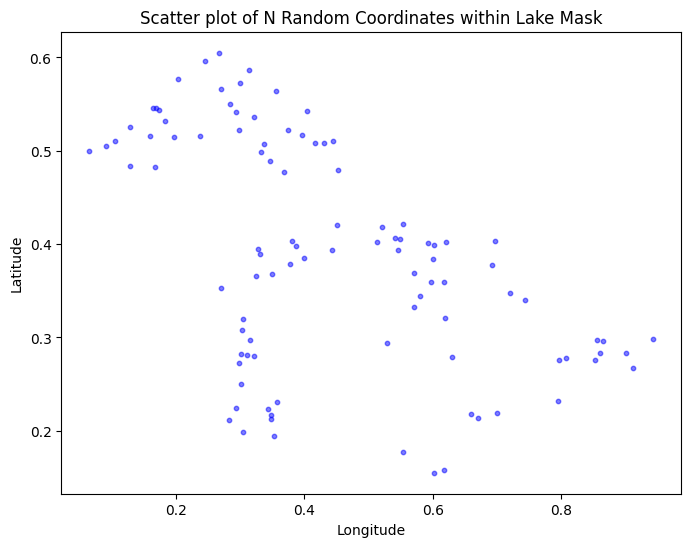

In [17]:
import matplotlib.pyplot as plt

# Assuming random_coords is the (2, N) array from the previous step
latitudes = random_lake_points[0, :]
longitudes = random_lake_points[1, :]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(longitudes, latitudes, color='blue', alpha=0.5, s=10)
plt.title("Scatter plot of N Random Coordinates within Lake Mask")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## Step 7: Task Generation for Model Training

In this section, we use **TaskLoader** to generate tasks. A task consists of context data (input features like sea surface temperature, bathymetry, etc.) and target data (what we want the model to predict, such as ice concentration).

We generate tasks for training by sampling from the datasets. Each task represents a training example that the model will learn from.


In [34]:
task_loader = TaskLoader(context=[glsea, aux_ds, lakemask], target=glsea)
task_loader
#task_loader = TaskLoader(context=glsea, target=glsea)

TaskLoader(3 context sets, 1 target sets)
Context variable IDs: (('sst',), ('bathymetry', 'cos_D', 'sin_D'), ('mask',))
Target variable IDs: (('sst',),)

Context data dimensions: (1, 3, 1)
Target data dimensions: (1,)

In [19]:
from tqdm import tqdm

# Define how Tasks are generated
def gen_tasks(dates, progress=True):
    tasks = []
    for date in tqdm(dates, disable=not progress):
        # Create task with context and target sampling
        task = task_loader(date, context_sampling=random_lake_points, target_sampling="all")
        
        # Remove NaNs from the target data (Y_t) in the task 
        # Target data cannot have NaNs
        task = task.remove_target_nans()
        
        # Append the processed task to the list
        tasks.append(task)
        
    return tasks

In [20]:
# Generate training and validation tasks
train_dates = pd.date_range(train_range[0], train_range[1])[::date_subsample_factor]
val_dates = pd.date_range(val_range[0], val_range[1])[::date_subsample_factor]

# Standardize the dates so they are datetime64[D] (date only, no time)
train_dates = pd.to_datetime(train_dates).normalize()  # This will set the time to 00:00:00
val_dates = pd.to_datetime(val_dates).normalize()      # This will set the time to 00:00:00

# Generate the tasks
train_tasks = gen_tasks(train_dates)
val_tasks = gen_tasks(val_dates)

100%|██████████| 13/13 [00:42<00:00,  3.24s/it]


In [22]:
train_tasks[10]

time: Timestamp/2009-10-28 00:00:00
ops: ['str/target_nans_removed']
X_c: ['ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)', 'ndarray/float32/(2, 100)']
Y_c: ['ndarray/float32/(1, 100)', 'ndarray/float32/(3, 100)', 'ndarray/float32/(1, 100)']
X_t: ['ndarray/float32/(2, 139599)']
Y_t: ['ndarray/float32/(1, 139599)']

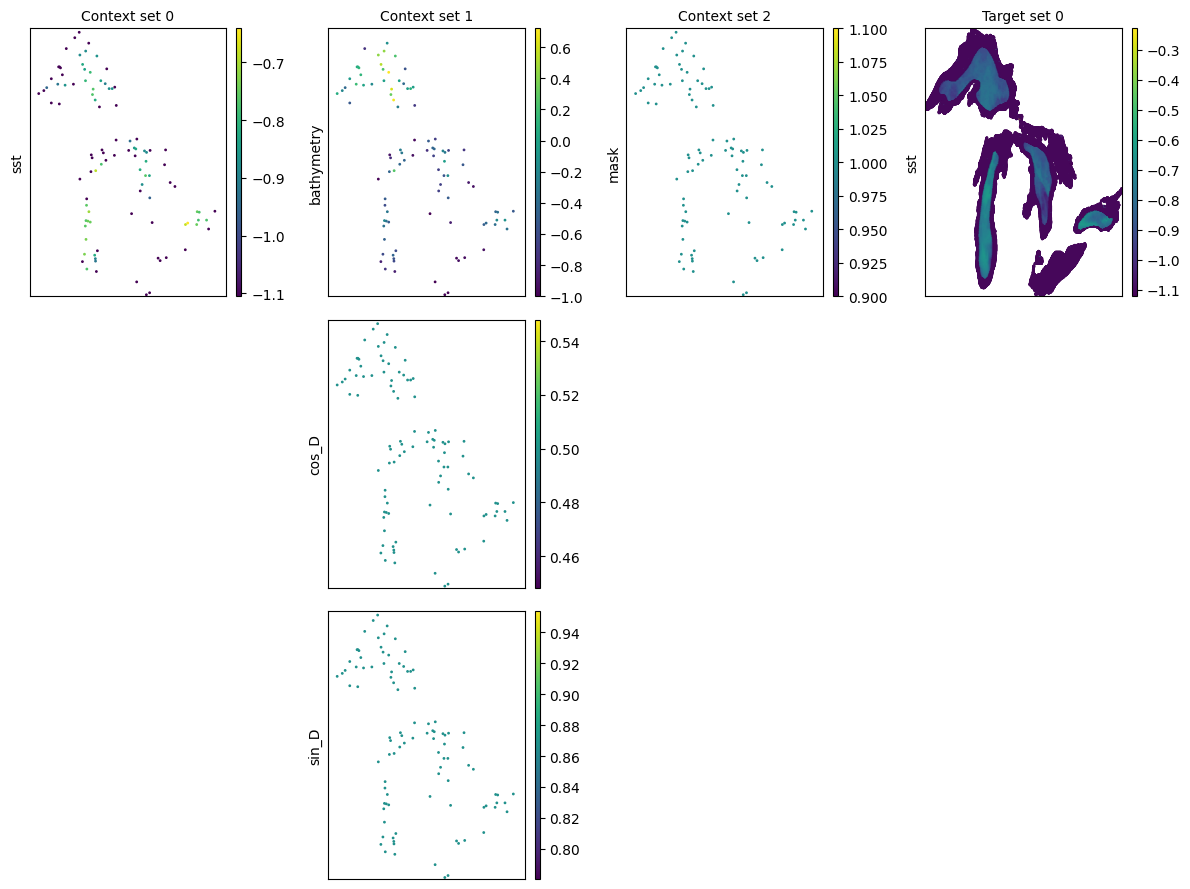

In [23]:
fig = deepsensor.plot.task(val_tasks[2], task_loader)
plt.show()

## Step 8: Model Setup and Training

We now set up the **ConvNP** model, a neural process-based model from **DeepSensor**. We use the **DataProcessor** and **TaskLoader** as inputs to the model, which allows the model to handle context and target data properly during training.

The model is then trained for a set number of epochs, and we monitor its performance by tracking the training loss and validation RMSE (Root Mean Squared Error).

At the end of the training loop, we save the best-performing model.


In [26]:
# Set up model
model = ConvNP(data_processor, task_loader)

dim_yc inferred from TaskLoader: (1, 3, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
internal_density inferred from TaskLoader: 1180
encoder_scales inferred from TaskLoader: [np.float32(0.0004237288), np.float32(0.0009355429), np.float32(0.0004237288)]
decoder_scale inferred from TaskLoader: 0.000847457627118644


In [27]:
# Define the Trainer and training loop
trainer = Trainer(model, lr=5e-5)

In [28]:
# Monitor validation performance
def compute_val_rmse(model, val_tasks):
    errors = []
    target_var_ID = task_loader.target_var_IDs[0][0]  # assuming 1st target set and 1D
    for task in val_tasks:
        mean = data_processor.map_array(model.mean(task), target_var_ID, unnorm=True)
        true = data_processor.map_array(task["Y_t"][0], target_var_ID, unnorm=True)
        errors.extend(np.abs(mean - true))
    return np.sqrt(np.mean(np.concatenate(errors) ** 2))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]/home/dannes/ds_env_gpu/lib/python3.10/site-packages/lab/types.py:178: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:
Training Epochs: 100%|██████████| 50/50 [13:24<00:00, 16.10s/it]


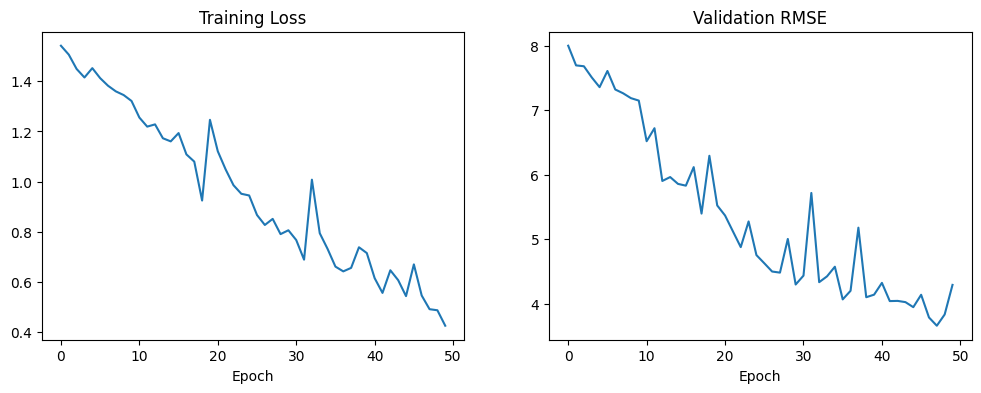

In [29]:
# Track the losses and validation RMSEs
losses = []
val_rmses = []
val_rmse_best = np.inf

# Start the training loop
for epoch in tqdm(range(50), desc="Training Epochs"):  # Training for 50 epochs
    # Generate tasks for training
    batch_losses = trainer(train_tasks)
    losses.append(np.mean(batch_losses))

    # Compute the validation RMSE
    val_rmse = compute_val_rmse(model, val_tasks)
    val_rmses.append(val_rmse)

    # Save the model if it performs better
    if val_rmse < val_rmse_best:
        val_rmse_best = val_rmse
        #model.save(deepsensor_folder)
        save_model(model, deepsensor_folder)

# Plot training losses and validation RMSE
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(losses)
axes[0].set_xlabel('Epoch')
axes[0].set_title('Training Loss')

axes[1].plot(val_rmses)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Validation RMSE')

plt.show()


In [30]:
# To load it later:
# Assuming you have data_processor and task_loader instantiated in your notebook
loaded_model = load_convnp_model(deepsensor_folder, data_processor, task_loader)
print("Model loaded successfully with custom function!")

Attempting to instantiate ConvNP model (randomly initialized initially):
Architectural config for construct_neural_process (passed as **kwargs): {'dim_x': 2, 'dim_yc': [1, 3, 1], 'dim_yt': 1, 'dim_aux_t': 0, 'dim_lv': 0, 'conv_arch': 'unet', 'unet_channels': [64, 64, 64, 64], 'unet_resize_convs': True, 'unet_resize_conv_interp_method': 'bilinear', 'aux_t_mlp_layers': None, 'likelihood': 'het', 'unet_kernels': 5, 'internal_density': 1180, 'encoder_scales': [0.0004237288, 0.0009355429, 0.0004237288], 'encoder_scales_learnable': False, 'decoder_scale': 0.000847457627118644, 'decoder_scale_learnable': False, 'num_basis_functions': 64, 'epsilon': 0.01}
Model loaded successfully with custom function!


### Try a Sample Prediction

In [38]:
date = "2010-02-14"
test_task = task_loader(date, context_sampling=random_lake_points, target_sampling="all")
pred = loaded_model.predict(test_task, X_t=glsea_raw)
pred

{'sst': <xarray.Dataset> Size: 8MB
 Dimensions:  (time: 1, lat: 838, lon: 1181)
 Coordinates:
   * lat      (lat) float64 7kB 38.87 38.89 38.9 38.92 ... 50.58 50.59 50.61
   * lon      (lon) float64 9kB -92.42 -92.41 -92.39 ... -75.91 -75.9 -75.88
   * time     (time) datetime64[ns] 8B 2010-02-14
 Data variables:
     mean     (time, lat, lon) float32 4MB 10.06 10.06 10.06 ... 10.06 10.06
     std      (time, lat, lon) float32 4MB 5.814 5.814 5.814 ... 5.814 5.814}

Note that the prediction produces both a mean prediction and a standard deviation, which is a characteristic of a Gaussian Process approach. 

# Conclusion

In this notebook, we:
1. Loaded and preprocessed several Great Lakes datasets for training a **ConvNP** model.
2. Generated tasks using **TaskLoader** and visualized data to perform sanity checks.
3. Trained the **ConvNP** model and monitored its performance.

Next, we will explore the active learning component of **DeepSensor**.
